In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '/home/bertinelli/pod_compastro23/Fireworks/fireworks_test'
data = np.load(path + '/data/ass_3/data_tusnami_e0.00.npz', allow_pickle=True)

In [3]:
# data_000001 = data['1e-05'][::1000]
# data_00001 = data['0.0001']
data_0001 = data['0.001']

0.019332839551879047

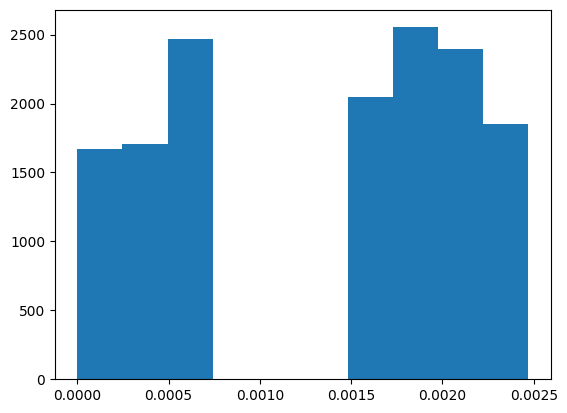

In [9]:
plt.hist(data_0001[:,5])

data_0001[5][-1]

ValueError: 'viridis' is not a valid value for color

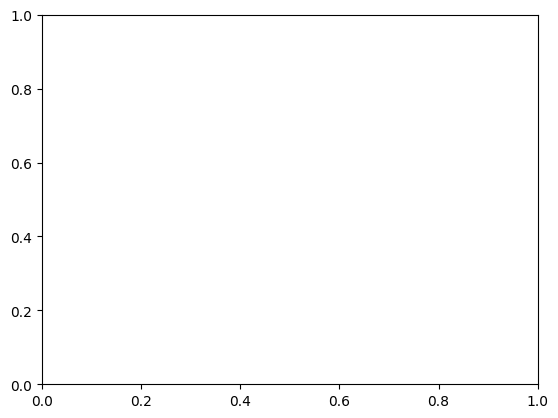

In [19]:
plt.plot(data_0001[:, 2][::500], data_0001[:, 3][::500], color='viridis')
plt.show()

In [29]:
# print(data_000001.shape)
# print(data_00001.shape)
print(data_0001.shape)

(19869, 6)


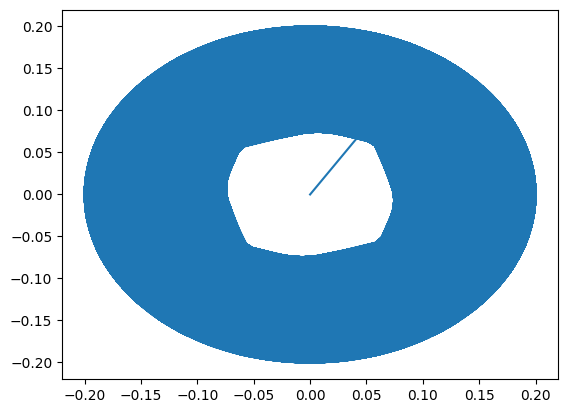

In [12]:
plt.plot(data_0001[:, 0], data_0001[:,1])
plt.show()

In [ ]:
import numpy as np
from matplotlib import pyplot as plt, animation as animation, ticker as mticker
from tqdm.notebook import tqdm

from fireworks.particles import Particles
import fireworks.ic as ic
import fireworks.nbodylib.dynamics as fnd
import fireworks.nbodylib.integrators as fni
import fireworks.nbodylib.timesteps as fnt
np.random.seed(9725)

In [ ]:
fig = plt.figure(figsize=(15, 15), layout='tight')
iplot = 330
# for e in [0.5, 0.9, 0.99]:
for e in [0.5]:
    rp = 1
    a = rp / (1 - e)
    part = ic.ic_two_body(mass1=8., mass2=2, e=e, rp=rp)
    Tperiod = 2 * np.pi * np.sqrt(a**3 / (part.mass[0] + part.mass[1]))
    N_end = 10
    dt = 0.01
    tintermediate=np.linspace(start=0, stop=N_end*Tperiod, num=int(10*Tperiod/dt))
    N_ts = int(np.floor(N_end*Tperiod/dt))
    pos_list=[]
    vel_list=[]
    energy_list=[]
    tstep = []
    dt_copy = dt#.copy()
    tot_time = 0
    N_ts_cum = 0
    for t in tqdm(tintermediate):
        
        # particles, efftime,_,_,_= fni.integrator_tsunami(particles,tstep)
        part, dt_copy ,_,_,_= fni.integrator_rk4(part, dt_copy, acceleration_estimator=fnd.acceleration_direct_vectorized)


        # Save the particles positions and velocities and energy
        pos_list.append(part.pos.copy())
        vel_list.append(part.vel.copy())
        Etot, _, _ = part.Etot()
        energy_list.append(Etot)
        tstep.append(dt_copy)
        dt_copy = fnt.adaptive_timestep(integrator=fni.integrator_rk4, int_args={'particles': part,
                                                                                'tstep': dt_copy,
                                                                                'acceleration_estimator': fnd.acceleration_direct_vectorized}, int_rank=4,
                                    predictor=fni.integrator_heun, pred_args={'particles': part,
                                                                                'tstep': dt_copy,
                                                                                'acceleration_estimator': fnd.acceleration_direct_vectorized}, pred_rank=2,
                                    epsilon = 1e-06)
        # Here we can save stuff, plot stuff, etc.
        tot_time += dt_copy
        N_ts_cum += 1

        if tot_time >= N_end*Tperiod:
            print('Exceeded time limit')
            break
        elif N_ts_cum >= 10*N_ts:
            print('Exceeded number of time steps')
            break

    
    pos_x_1, pos_y_1 = np.array(pos_list)[:, 0][:, 0], np.array(pos_list)[:, 0][:, 1] 
    pos_x_2, pos_y_2 = np.array(pos_list)[:, 1][:, 0], np.array(pos_list)[:, 1][:, 1] 

    #position plot
    iplot +=1
    ax = fig.add_subplot(iplot)
    ax.plot(pos_x_1, pos_y_1, label=f'Mass 1')
    ax.plot(pos_x_2, pos_y_2, label=f'Mass 2')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'e={e}')
    ax.legend()
    
    #energy plot
    iplot +=1
    ax = fig.add_subplot(iplot)
    ax.plot(energy_list, label='Tot energy')
    ax.set_xlabel('time')
    ax.set_ylabel('E')
    ax.legend()
    
    #energy error
    iplot +=1
    ax = fig.add_subplot(iplot)
    energy_array = np.array(energy_list)
    error = np.abs(energy_array - energy_array[0])/energy_array[0]
    ax.set_xlabel('time')
    ax.plot(error, label='error')
    ax.set_ylabel(r'$\frac{|E-E_0|}{E_0}$')
    ax.legend()
